# Probabilistic flakiness score

In the continuous integration (CI) project workflow, developers frequently integrate code into a shared repository. Each integration can then be verified by an automated build and tests. Whenever a failure occurs in a test, developers need to manually analyze failures. Failures in the build can be legitimate or due to some other issues like an infrastructure flake, install flake, flaky test, or some other type of failure. SME's can analyze the TestGrid data manually and determine if failures appear to be legitimate or not. However, it takes a lot of human effort and reduces the productivity of a team. In this notebook we will try to reliably detect Flaky test using probabilistic flakiness score. 

## What is a flaky test?

A flaky test is one that passes or fails in a nondeterministic way. [See this paper for more details](http://mir.cs.illinois.edu/~eloussi2/publications/fse14.pdf). 

In data science terms, if a test passes and fails in an apparently random sequence then it is likely to be a flake. Tests can also be considered flaky if they pass and fail in a non-random but inconsistent pattern. Therefore, our goal here is to develop a technique for finding apparently random or inconsistent pass/fail sequences, which we can then apply to the TestGrid dataset. 

In [135]:
import os
import sys
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import warnings

import gzip
import json

import pystan

sns.set()
warnings.filterwarnings("ignore")

In [5]:
# adding path to notebook consisting of modules to be imported
module_path = os.path.abspath(os.path.join("../../data-sources/TestGrid"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from ipynb.fs.defs.testgrid_EDA import decode_run_length

## Data Access

_In depth details for data access and preprocessing can be found in the [testgrid_EDA notebook](../../data-sources/TestGrid/testgrid_EDA.ipynb)._ 

Here we provide two data access methods: download the latest or use example data. If you would like to download the most recent data for a specific grid, then please set `download_data` to `True` on line #2 below and update `dashboard_name` and `job_name` appropriately. Be warned, the output and results will likely change if the most recent data is used instead of the fixed example data.   

Otherwise, we will use the repo's example dataset `data/raw/testgrid_810.json.gz`

Regardless of the method used, we will be looking at "redhat-openshift-ocp-release-4.6-informing/periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-proxy" as our example throughout. 

In [122]:
## Do you want to use download data or stored data?
download_data = False

dashboard_name = "redhat-openshift-ocp-release-4.6-informing"
job_name = "periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-proxy"

if download_data:
    payload = {"show-stale-tests": job_name, "tab": job_name}
    response = requests.get(
        "https://testgrid.k8s.io/" + dashboard_name + "/table", params=payload
    )
    details = pd.DataFrame(response.json()["tests"]).drop(
        [
            "linked_bugs",
            "messages",
            "user_property",
            "target",
            "original-name",
        ],
        axis=1,
    )
else:
    with gzip.open("data/raw/testgrid_810.json.gz", "rb") as read_file:
        data = json.load(read_file)
    details = data['"' + dashboard_name + '"'][job_name]["grid"]
    details = pd.DataFrame(details)

details.head(10)

,name,statuses
0,Overall,"[{'count': 21, 'value': 12}, {'count': 1, 'val..."
1,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
2,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
3,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
4,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
5,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 1}, {'count': 1, 'value..."
6,[sig-api-machinery][Feature:APIServer][Late] k...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu..."
7,[sig-auth][Feature:SCC][Early] should not have...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu..."
8,[sig-arch] Monitor cluster while tests execute,"[{'count': 20, 'value': 0}, {'count': 20, 'val..."
9,[sig-node] pods should never transition back t...,"[{'count': 20, 'value': 0}, {'count': 18, 'val..."


From the column "statuses" above we can see that the time series data is run length encoded. Let's add a decoded column so we can get the data in an easier to use array format.

In [123]:
# use the decode_run_length function imported from TestGrid_EDA notebook
details["values"] = details["statuses"].apply(decode_run_length)

In [124]:
details.head(10)

,name,statuses,values
0,Overall,"[{'count': 21, 'value': 12}, {'count': 1, 'val...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
1,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12..."
2,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12..."
3,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12..."
4,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 0, 12, 12..."
5,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 1}, {'count': 1, 'value...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
6,[sig-api-machinery][Feature:APIServer][Late] k...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,[sig-auth][Feature:SCC][Early] should not have...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,[sig-arch] Monitor cluster while tests execute,"[{'count': 20, 'value': 0}, {'count': 20, 'val...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,[sig-node] pods should never transition back t...,"[{'count': 20, 'value': 0}, {'count': 18, 'val...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


TestGrids are made of a set of tests that either pass or fail over time. They are multidimensional time series where the values can take either 0 (not run), 1 (pass), 12 (fail), or 13(flaky). 

Now that we have all our data unrolled, lets plot it. We will use green for pass (1), red for fail (12), white for not run (0) and purple for flaky (13). We will also just plot the first 40 rows to save some space.

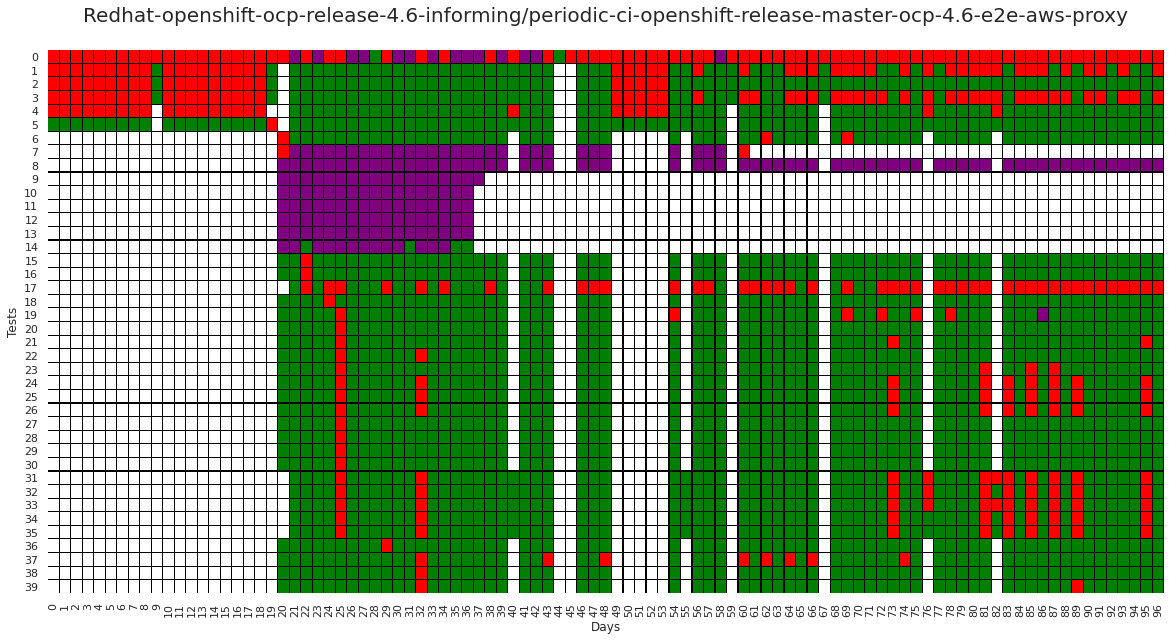

In [125]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red", "purple"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12, 13], ncolors=3)
sns.heatmap(
    np.array(list(details["values"].values))[:40],
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title(
    "Redhat-openshift-ocp-release-4.6-informing/periodic-ci-\
openshift-release-master-ocp-4.6-e2e-aws-proxy\n",
    fontsize=20,
)
plt.show()

Cells with Purple color in the above graph are the existing flake labels defined by the build process. Currently, each failed test is retried, and if it passes on a subsequent run it is considered to be flaky.

We can see from the grid above that there is a large chunk of flakes between test 7 and 15, but there is also a fair amount of irregular pass/failure patterns on the grid that are not being flagged. Let's see if we can create a method to better capture these flakes.

## Probabilstic flakiness score
For training we need flakiness score which is dependent variable, we calculated the flakiness score as the number of edges divided by total runs. Independent variables are the number of edges and non edges. Edge as the transition of a particular test case from pass to fail (or fail to pass)

In [157]:
def calc_consecutive_failures(test_row, i):
    """This function calculates number of consecutive failures

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12 values as not run, pass, fail respectively
    i : float, int
            index in array i

    Returns
    ----------
    result: int
            number of consecutive failures from index i
    """

    result = 0
    while i < len(test_row) and (test_row[i] == 12 or test_row[i] == 0):
        if test_row[i] == 12:
            result += 1
        i += 1
    return result


def calc_edges(test_row, ignore_failures_in_a_row=3):
    """This function calculates flakiness score as the number of edges divided by total runs.
    At google, If the test is failing three times in a row, then only it reported as real failures;
    otherwise, it's considered a flaky test.
    (https://testing.googleblog.com/2016/05/flaky-tests-at-google-and-how-we.html)
    Hence, we ignored three or more than three consecutive failures
    and test cases that are not run while calculating the flakiness score.

    We always consider label 13 as an edge.
    since currently, each failed test is retry, and if it's passed on a subsequent run it is considered as flaky.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flakiness: float
            Flakiness score lies between 0 and 100; 0 is no flakiness, and 100 is maximum flakiness.
    flip_edges: int
            Number of edges in the test run
    flip_not_edges: int
            Number of non-edges in the test run
    """
    flips = 0
    i = 0
    ## ignore not run instances in the starting
    while i < len(test_row) and test_row[i] == 0:
        i += 1

    ## intializing last_passing variable value
    if i >= len(test_row):
        return 0.0001/100, 0, len(test_row)
    elif test_row[i] == 1:
        last_passing = True
    elif test_row[i] == 13:
        last_passing = True
        flips += 1
    elif test_row[i] == 12:
        last_passing = False
    else:
        last_passing = True
    considerd = 1
    i += 1
    pass_n = 0
    fail_n = 0

    while i < len(test_row):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we considered did not consider it an edge.
        cf = calc_consecutive_failures(test_row, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_row):
                break

        s = test_row[i]
        if s == 1:
            ## run is pass
            considerd += 1
            last_passing = True
            pass_n += 1
        elif s == 0:
            ## not run
            pass
        elif s == 13:
            ## flaky
            flips += 1
            considerd += 1
            last_passing = True
            pass_n += 1
            fail_n += 1
        elif s == 12:
            ## run is fail
            considerd += 1
            fail_n += 1
            if last_passing:
                flips += 1
            last_passing = False
        i += 1
    if considerd == 0:
        return 0, flip_arr
    ## multiplying by 2 since flakiness score lies between 0 and 100
    ## added 0.0001 since beta regression didnt work for 0 values
    flakiness = (flips / (considerd)) * 100
    if flakiness==0:
        flakiness = 0.0001
    elif flakiness==100:
        flakiness = 1-0.0001
    return flakiness/100, flips, considerd-flips

In [158]:
details["flip_flakiness_score"] = details["values"].apply(
    lambda x: calc_edges(x)[0]
)

details["flip_edges"] = details["values"].apply(
    lambda x: calc_edges(x)[1]
)

details["flip_not_edges"] = details["values"].apply(
    lambda x: calc_edges(x)[2]
)

In [159]:
details

,name,statuses,values,flip_flakiness_score,flip_edges,flip_not_edges
0,Overall,"[{'count': 21, 'value': 12}, {'count': 1, 'val...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",0.916667,22,2
1,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12...",0.140351,8,49
2,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12...",0.000001,0,72
3,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12...",0.129630,7,47
4,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 0, 12, 12...",0.043478,3,66
...,...,...,...,...,...,...
1079,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 1}, {'count': 1, 'value...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",0.000001,0,91
1080,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 1}, {'count': 1, 'value...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",0.000001,0,91
1081,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 20, 'value': 1}, {'count': 1, 'valu...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,0,94
1082,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 20, 'value': 1}, {'count': 1, 'valu...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,0,94


### Beta Regression
Beta regression is a technique that has been proposed for modelling of data for which the observations are limited to the open interval (0, 1) [ref](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.13234#:~:text=Beta%20regression%20is%20a%20technique,Smithson%20%26%20Verkuilen%2C%202006). Beta regression begins with the assumption that the data‐generating process can reasonably be modelled by a beta probability distribution

In [160]:
stan_beta = """  
data {
  int<lower=1> N;
  int<lower=1> K;
  int<lower=1> J;
  vector<lower=0,upper=1>[N] y;
  matrix[N,K] X;
  matrix[N,J] Z;
}
parameters {
  vector[K] beta;
  vector[J] gamma;
  vector<lower=0,upper=1>[N] y_new;
}
transformed parameters{
  vector<lower=0,upper=1>[N] mu;    
  vector<lower=0>[N] phi;           
  vector<lower=0>[N] A;             
  vector<lower=0>[N] B;

  for (i in 1:N) {
    mu[i]  = inv_logit(X[i,] * beta);   
    phi[i] = exp(Z[i,] * gamma);
  }

  A = mu .* phi;
  B = (1.0 - mu) .* phi;
}

model {
  // priors

  // likelihood
  y ~ beta(A, B);
  y_new ~ beta(A, B);
}
"""

In [161]:
X = details[['flip_edges', 'flip_not_edges']]
X[1] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]
y = details['flip_flakiness_score'].tolist()

In [163]:
data = {                                                                                             
    'N': len(y),   
    'K': 3,
    'J': 3,
    'y': y,
    'X': X,
    'Z': X
} 

parms = {
    'beta': [1,2,2],
    'gamma': [1, 8, 8],
    'y_new': y
}
sm = pystan.StanModel(model_code=stan_beta)                                                               
fit = sm.sampling(data=data, pars=parms)  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ae456fd2fd9fad4a5c3f17a4565d0c9 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [164]:
summary_dict = fit.summary()
fit_sum = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
fit_sum

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],-3.676276,0.421557,0.656032,-5.156177e+00,-4.113425,-3.524315,-3.357057,-2.338922,2.421795,3.273193
beta[2],0.407547,0.009550,0.021539,3.722003e-01,0.394016,0.404096,0.418260,0.455433,5.086354,1.572009
beta[3],-0.033100,0.006332,0.010003,-5.299851e-02,-0.038888,-0.034919,-0.026216,-0.010683,2.495721,3.081941
gamma[1],1.124833,0.399375,0.621048,-2.802180e-01,0.791477,1.097801,1.430068,2.540210,2.418181,3.135775
gamma[2],-0.058668,0.018172,0.030223,-1.371150e-01,-0.069895,-0.056100,-0.045385,-0.001975,2.766220,2.820911
...,...,...,...,...,...,...,...,...,...,...
y_new[1081],0.002106,0.000955,0.004919,2.595400e-09,0.000003,0.000116,0.001550,0.017832,26.545730,1.206997
y_new[1082],0.001885,0.001109,0.005259,3.401179e-07,0.000011,0.000129,0.001005,0.018219,22.483533,1.137791
y_new[1083],0.000489,0.000282,0.001423,5.642195e-08,0.000007,0.000044,0.000263,0.004420,25.422494,1.160071
y_new[1084],0.001504,0.001148,0.003020,1.514377e-09,0.000003,0.000132,0.001784,0.011037,6.917784,1.273122


(array([4.67250923e+01, 1.75276753e+00, 3.69003690e-01, 2.30627306e-01,
        9.22509225e-02, 4.61254613e-02, 0.00000000e+00, 0.00000000e+00,
        4.61254613e-02, 0.00000000e+00, 1.38376384e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.61254613e-02, 4.61254613e-02, 4.61254613e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.61254613e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.15129151e-01]),
 array([2.22044605e-16, 2.00000000e-02, 4.00000000e-02, 6.00000000e-02,
        8.00000000e-02

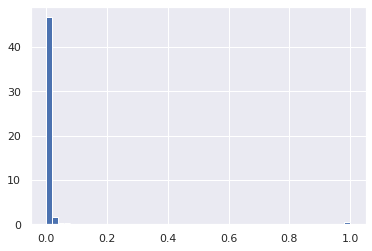

In [170]:
plt.hist(fit.extract()['y_new'][0], bins= 50, density=True)

# Conclusion